# Evaluación de modelos entrenados

In [3]:
import os
# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

2025-05-25 10:51:12.951057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748166672.968531   27477 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748166672.975035   27477 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Carga de modelo

In [4]:
# Define the model architecture again (same as during training)
learning_rate = 0.005 #Should not matter for predictions

past_shape = [17, 7]  # (time_steps, num_features)
future_shape = [6, 4]  # (time_steps, num_features)
target_dim=6
# Encoder part (LSTM for past data)
past_in   = tf.keras.layers.Input(shape=past_shape,   name="past_data")
future_in = tf.keras.layers.Input(shape=future_shape, name="future_data")

# Past data 
past_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(65, return_sequences=False))(past_in)
past_lstm = tf.keras.layers.Dense(65)(past_lstm)

# Future
decoder_lstm = tf.keras.layers.LSTM(4, return_sequences=False)(future_in)

# Combine the outputs of encoder and decoder (you can concatenate or merge them)
future_residue = tf.keras.layers.Flatten()(future_in)
merged = tf.keras.layers.concatenate([past_lstm, decoder_lstm, future_residue])

# Final output layer
merged = tf.keras.layers.Dense(4* target_dim)(merged)
outputs = tf.keras.layers.Dense(target_dim)(merged)

model = tf.keras.Model(inputs=[past_in, future_in], outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "../trained_models/t_f6_4508.weights.h5"
model.load_weights(path_checkpoint)

# Optionally check the model summary to confirm weights have been loaded
model.summary()


I0000 00:00:1748166675.518557   27477 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1561 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_data           │ (None, 17, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 130)       │     37,960 │ past_data[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_data         │ (None, 6, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 65)        │      8,515 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 4)         │        144 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 24)        │          0 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 93)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ lstm_1[0][0],     │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24)        │      2,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │        150 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,025 (191.50 KB)

 Trainable params: 49,025 (191.50 KB)

 Non-trainable params: 0 (0.00 B)

/home/jr/miniconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_data           │ (None, 17, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 130)       │     37,960 │ past_data[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_data         │ (None, 6, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 65)        │      8,515 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 4)         │        144 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 24)        │          0 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 93)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ lstm_1[0][0],     │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24)        │      2,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │        150 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,025 (191.50 KB)

 Trainable params: 49,025 (191.50 KB)

 Non-trainable params: 0 (0.00 B)

## Datos entrenamiento

In [5]:
DATA_PATH = "../../3_data_windows/f6/paquetes_s6_cov_full_p17.pkl"
#DATA_PATH = "../3_data_windows/f3/paquetes_s6_cov_sc_p17.pkl"

BATCH_SIZE = 64

with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)
    
x_val = data["test"]["air_temperature"]["past_variables"]
future_val = data["test"]["air_temperature"]["future_variables"]
y_val = data["test"]["air_temperature"]["y"]

dataset_val = tf.data.Dataset.from_tensor_slices(((x_val, future_val), y_val))
dataset_val = dataset_val.batch(BATCH_SIZE)


In [6]:
predictions_all = []
y_true_all = []

for batch in dataset_val:
    (x_past, x_future), y = batch
    predictions = model.predict((x_past, x_future))

    # Convert to numpy arrays and flatten
    y_np           = y.numpy().reshape(-1)
    predictions_np = predictions.reshape(-1)
    
    # Accumulate into lists
    y_true_all.extend(y_np.tolist())
    predictions_all.extend(predictions_np.tolist())

# Convert lists back to numpy arrays
y_true_arr      = np.array(y_true_all)
predictions_arr = np.array(predictions_all)


MEAN = data["train"]["air_temperature"]["mean"][-1]
STD = data["train"]["air_temperature"]["std"][-1]
# Calculate RMSE
mse = mean_squared_error(y_true_arr, predictions_arr)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
print("RMSE (scaled):", rmse * STD)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

I0000 00:00:1748166676.944688   27666 cuda_dnn.cc:529] Loaded cuDNN version 90800


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━

In [7]:
def denormalize(data, mean, std):
    """
    Denormalize the data using the mean and standard deviation.
    """
    return data * std + mean
  

In [8]:

MEAN = data["train"]["air_temperature"]["mean"][-1]
STD = data["train"]["air_temperature"]["std"][-1]

def plot_predictions(x_past, y, predictions):
# Denormalize
    history    = denormalize(x_past[:, -1], MEAN, STD)    # last feature over history window
    actual     = denormalize(y, MEAN, STD)
    forecast   = denormalize(predictions, MEAN, STD)

    H = len(history)
    F = len(actual)

    # Build continuous "actual" curve: history + actual future
    full_actual = np.concatenate([history, actual])

    # Build forecast curve that starts at the last history point
    # so its first value sits on history[-1]
    full_forecast = np.concatenate([[history[-1]], forecast])

    # Time axes
    t_full = np.arange(H + F)                            # for full_actual
    t_forc = np.arange(H - 1, H - 1 + len(full_forecast))  # for full_forecast

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(t_full,      full_actual,    label='Actual (history + future)', linewidth=2)
    plt.plot(t_forc,      full_forecast,  label='Forecast',               linestyle='--', linewidth=2)
    plt.axvline(H - 1,    linestyle=':',  linewidth=1.5,             label='Forecast start')
    plt.grid(alpha=0.3)
    plt.title('Time Series: History → Actual vs. Forecast')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predictions shape: 64


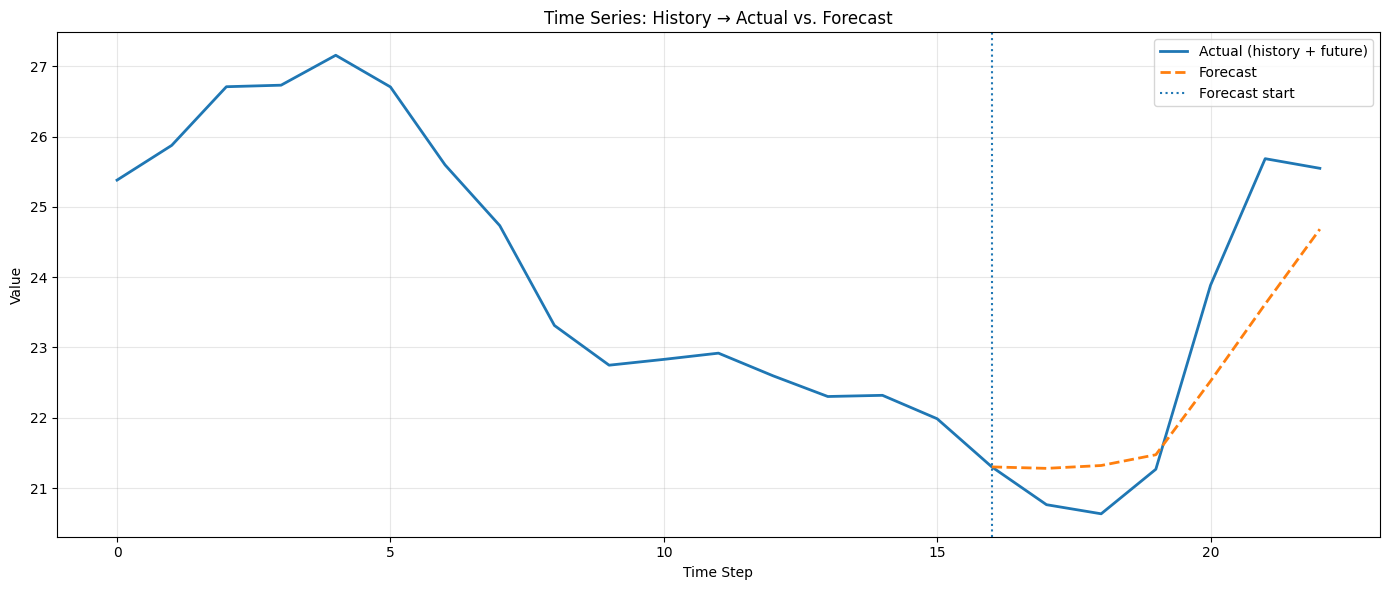

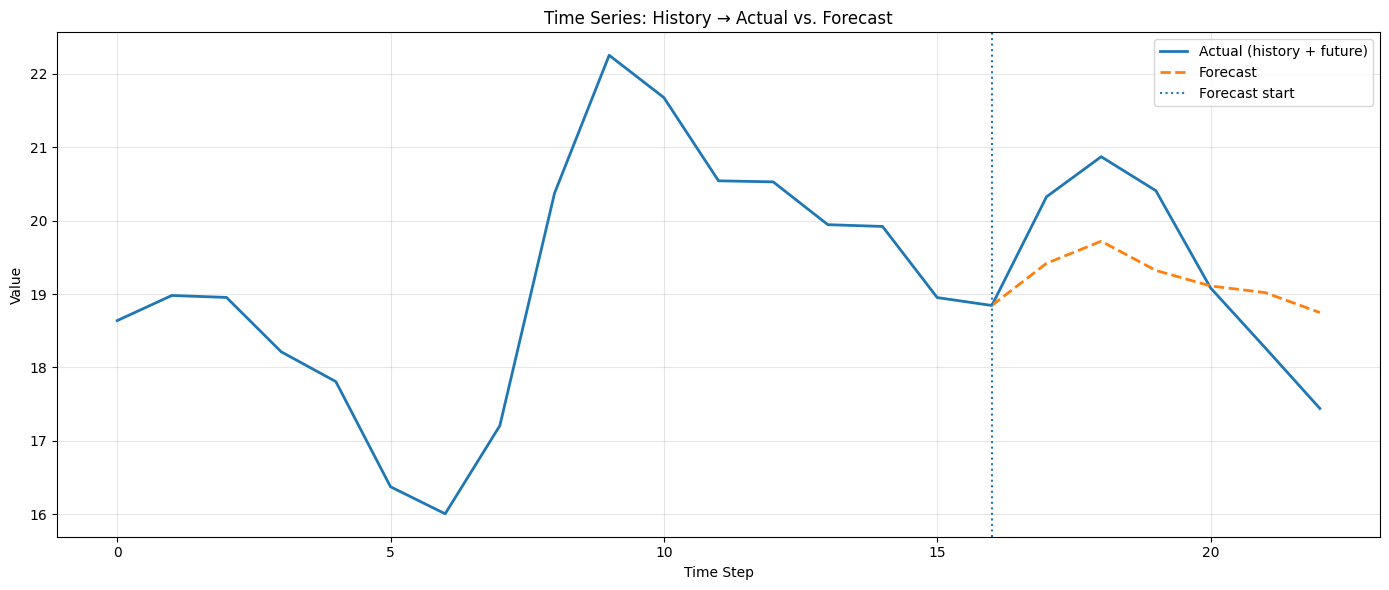

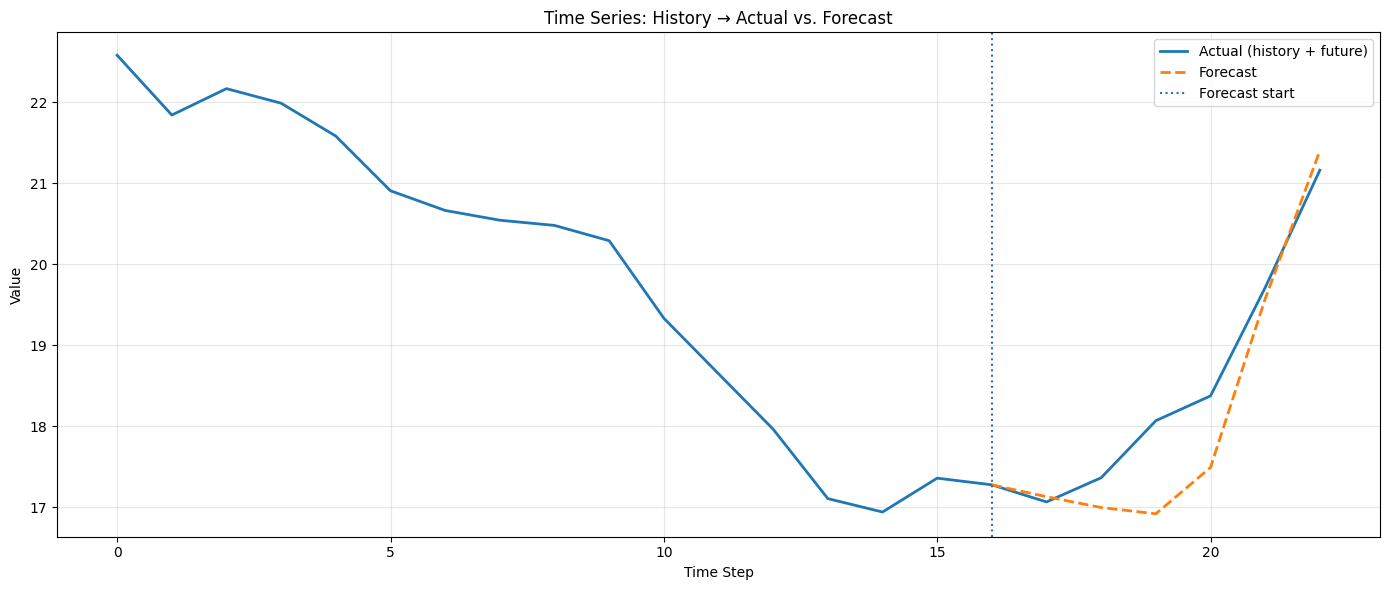

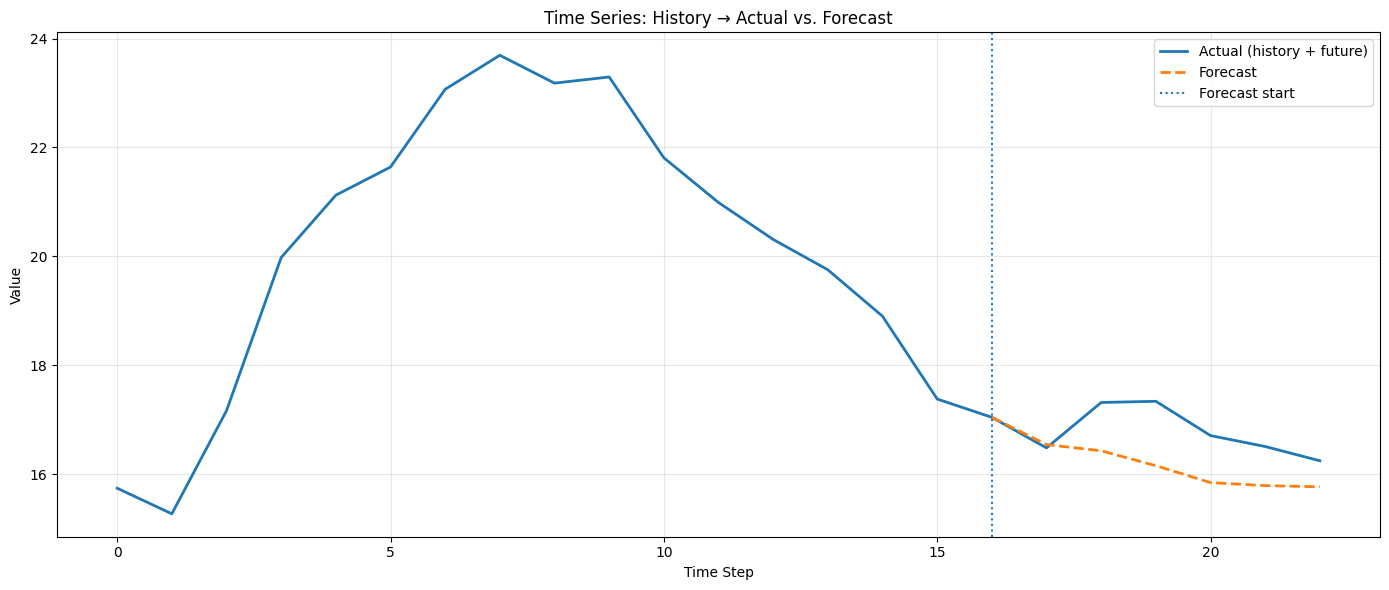

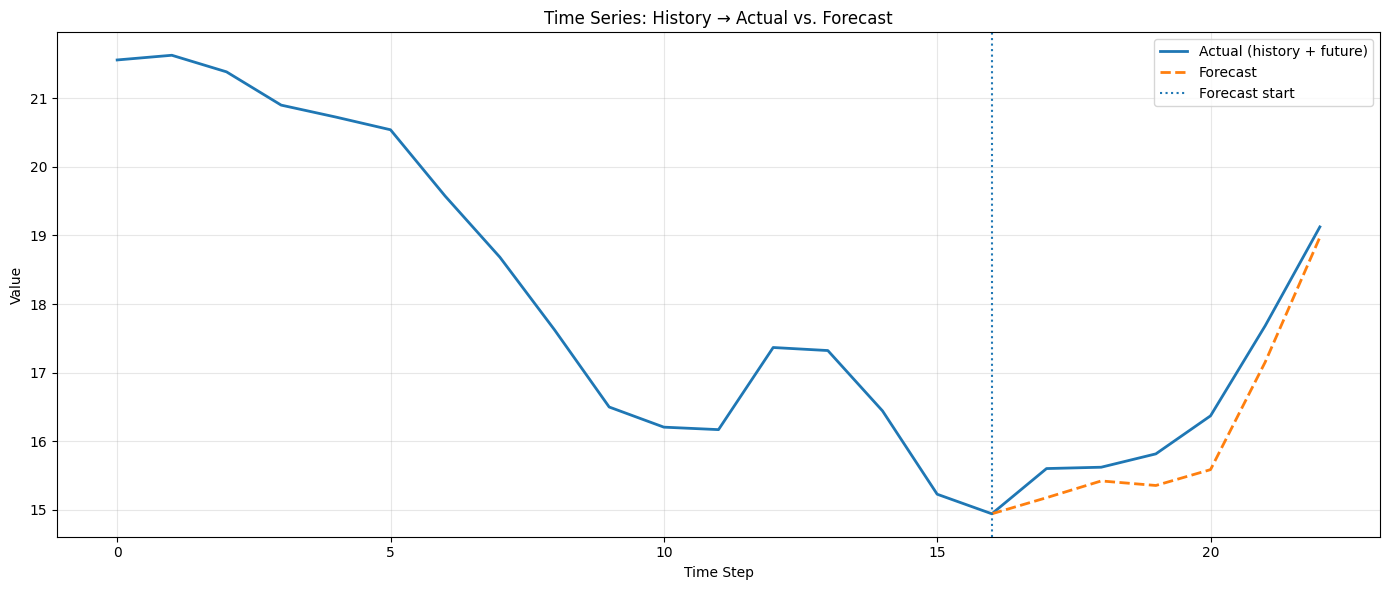

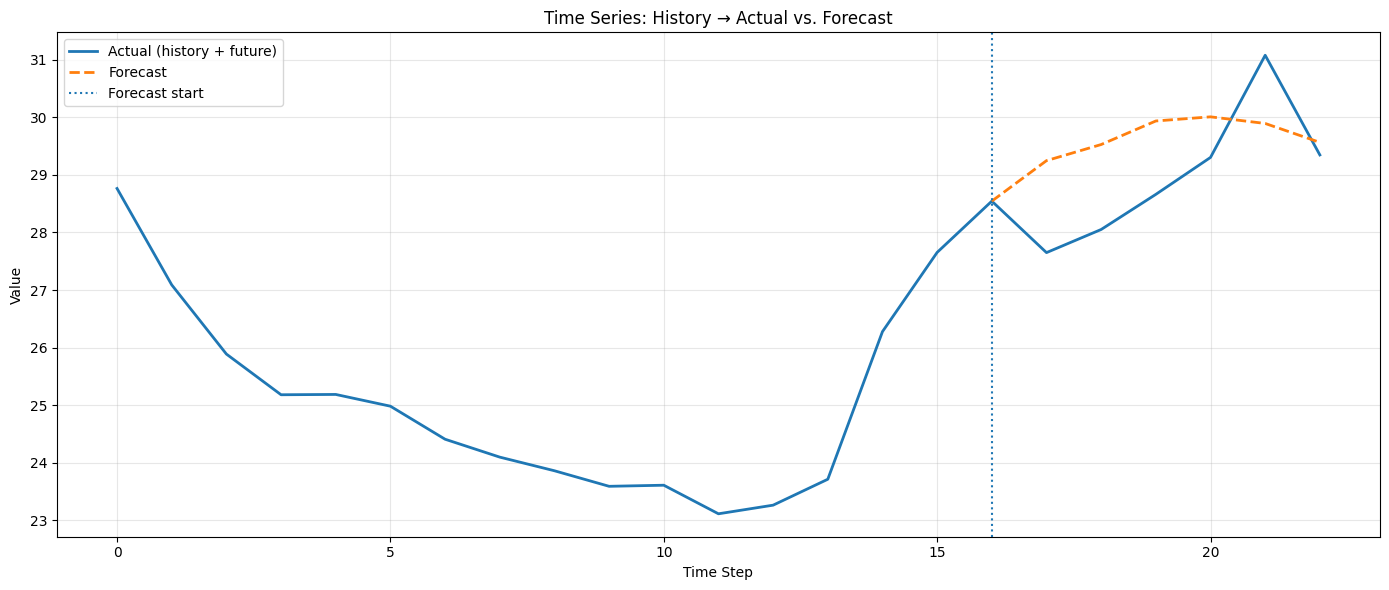

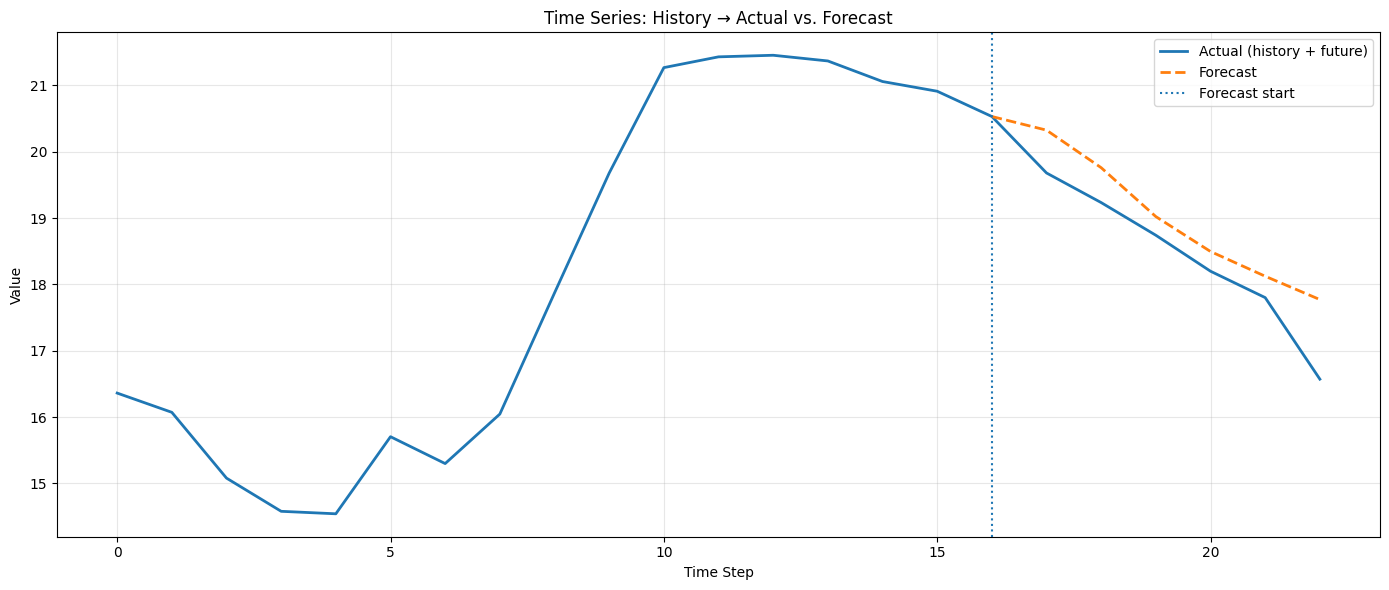

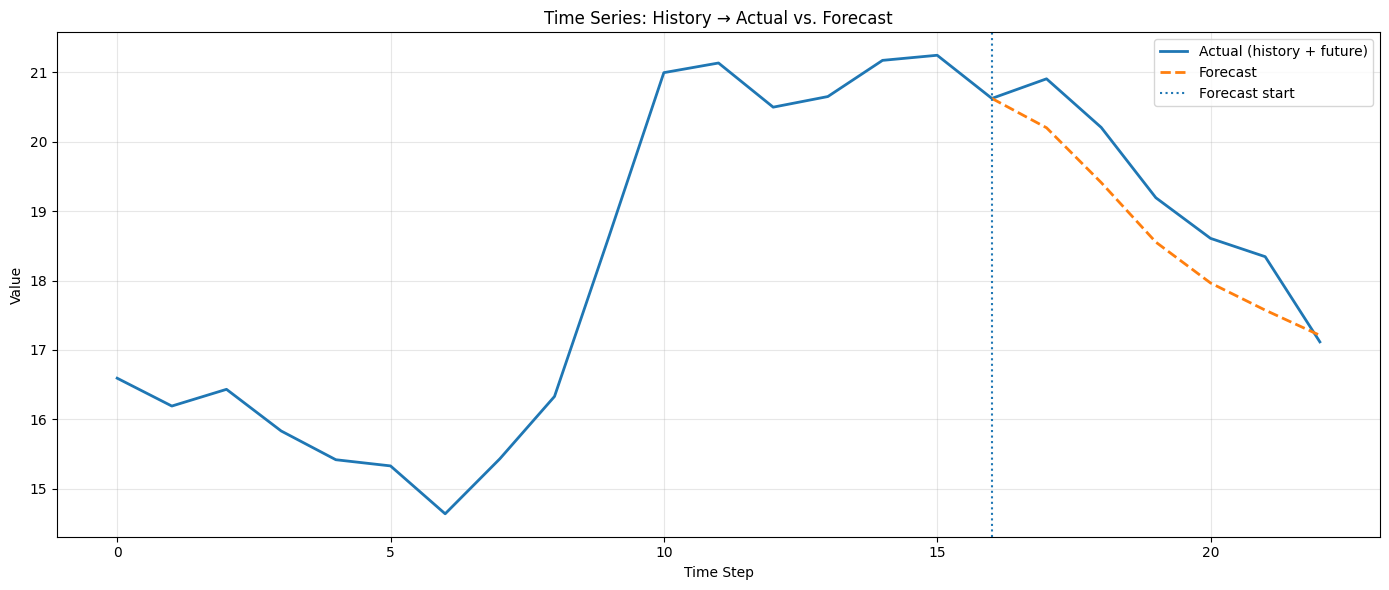

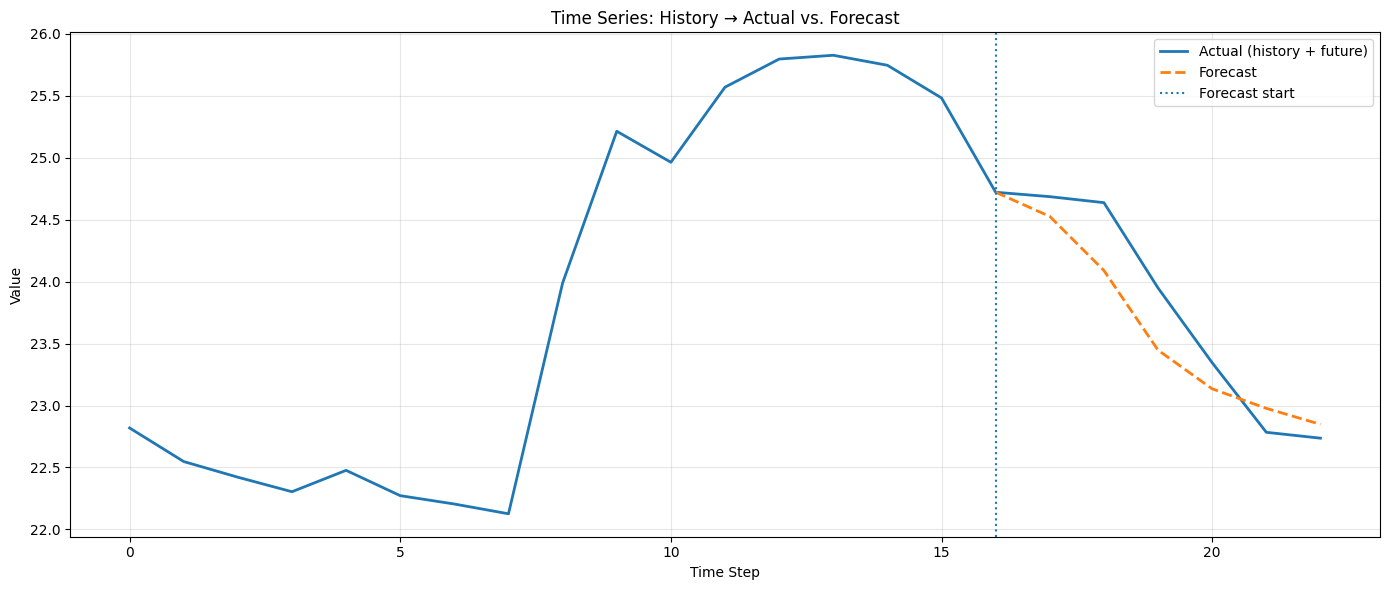

In [9]:

for batch in dataset_val.take(1):
    (x_past, x_future), y = batch
    predictions = model.predict((x_past, x_future))

    print("predictions shape:", predictions.shape[0])
    for i in range(0, 9):
        plot_predictions(x_past[i], y[i], predictions[i])
        plt.show()

## Validación

In [10]:
DATA_PATH = "../../3_data_windows/f6_val/paquetes_s6_cov_full_santa_cruz_p17.pkl"

BATCH_SIZE = 64

with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)
    
x_val = data["air_temperature"]["past_variables"]
future_val = data["air_temperature"]["future_variables"]
y_val = data["air_temperature"]["y"]

dataset_val = tf.data.Dataset.from_tensor_slices(((x_val, future_val), y_val))
dataset_val = dataset_val.batch(BATCH_SIZE)

In [11]:
predictions_all = []
y_true_all = []

for batch in dataset_val:
    (x_past, x_future), y = batch
    predictions = model.predict((x_past, x_future))

    # Convert to numpy arrays and flatten
    y_np           = y.numpy().reshape(-1)
    predictions_np = predictions.reshape(-1)
    
    # Accumulate into lists
    y_true_all.extend(y_np.tolist())
    predictions_all.extend(predictions_np.tolist())

# Convert lists back to numpy arrays
y_true_arr      = np.array(y_true_all)
predictions_arr = np.array(predictions_all)

# Calculate RMSE
mse = mean_squared_error(y_true_arr, predictions_arr)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
print("Denormalized RMSE:", rmse * STD)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
MSE: 0.03847551823652146
RMSE: 0.1961517734727919
Denormalized RMSE: 0.7892026527969934


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predictions shape: 64


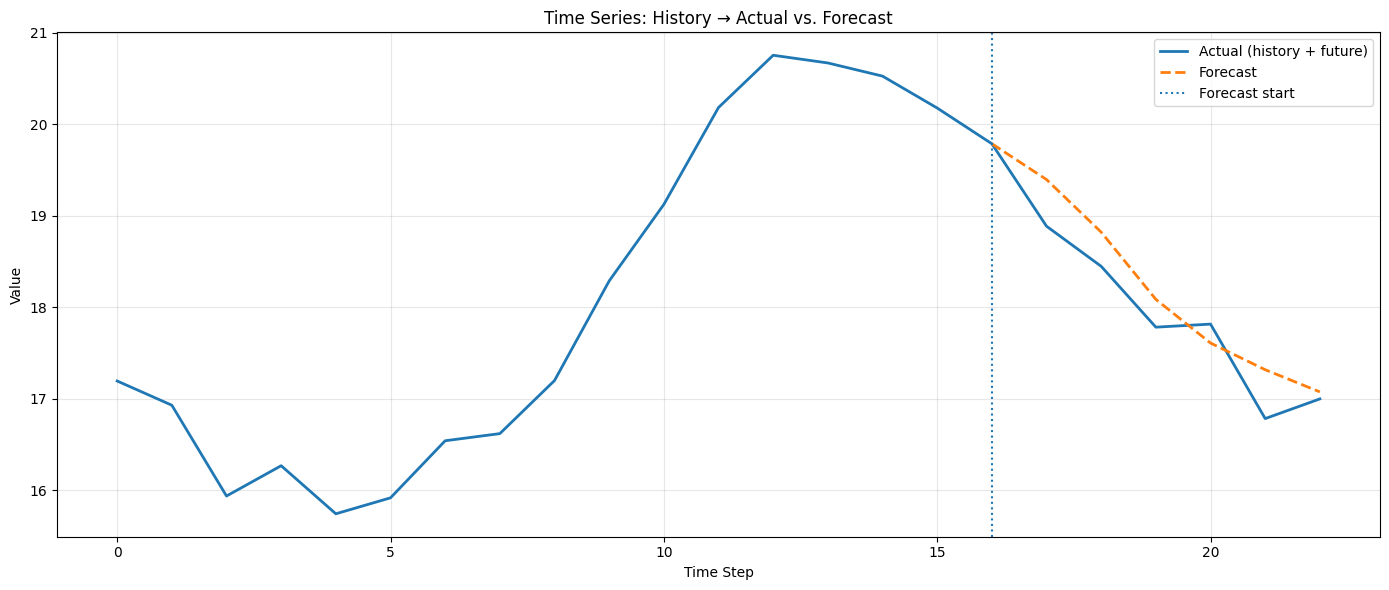

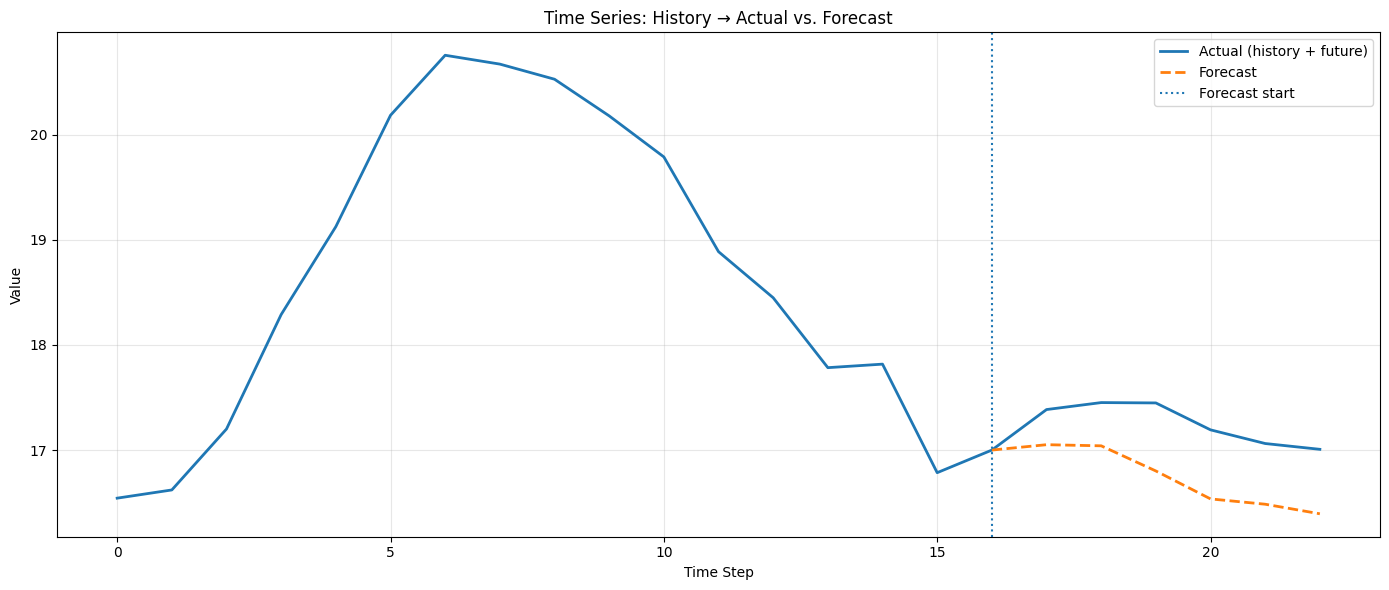

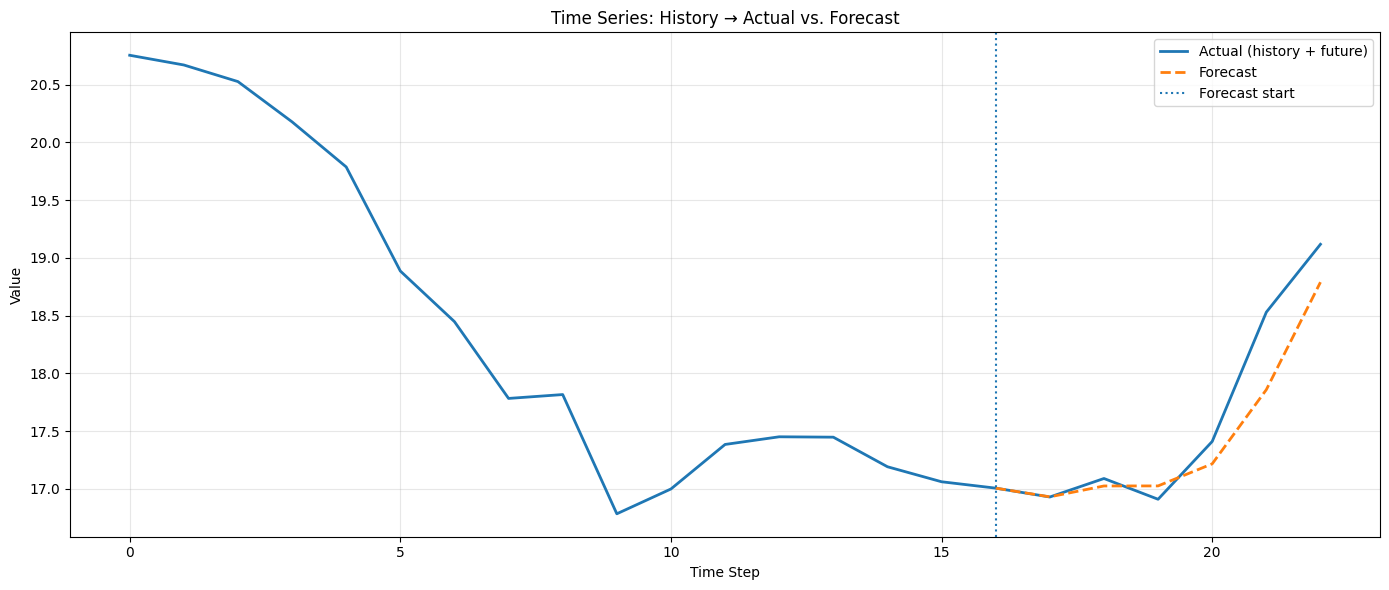

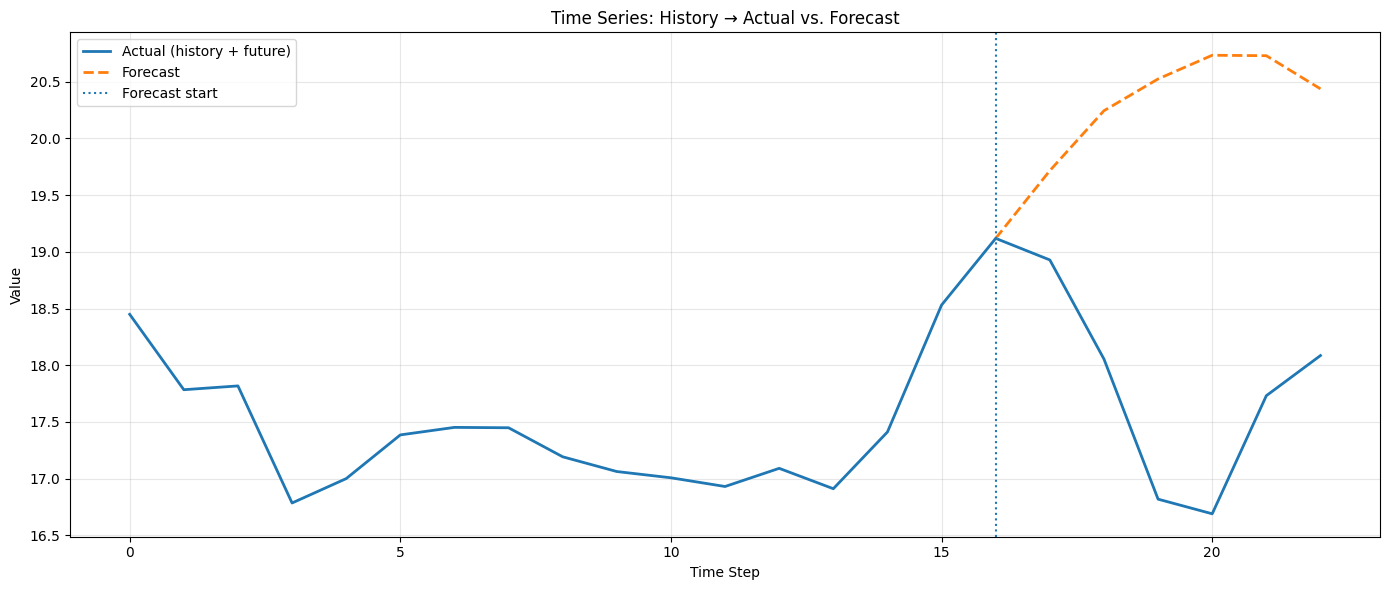

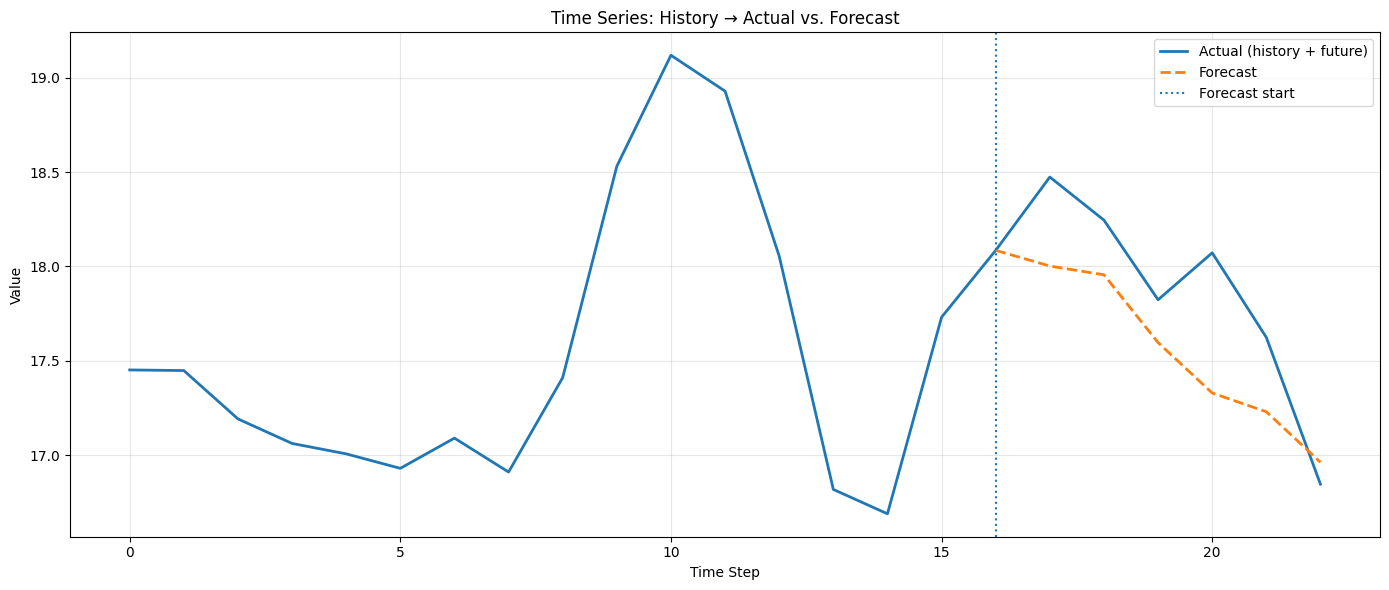

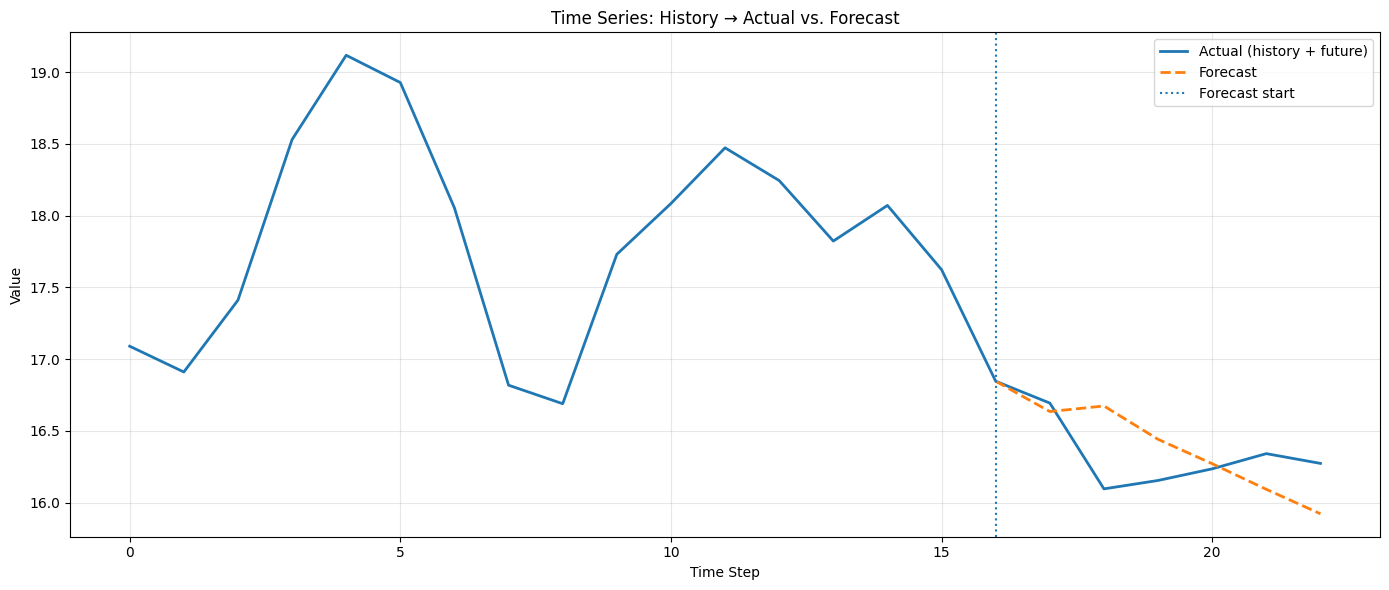

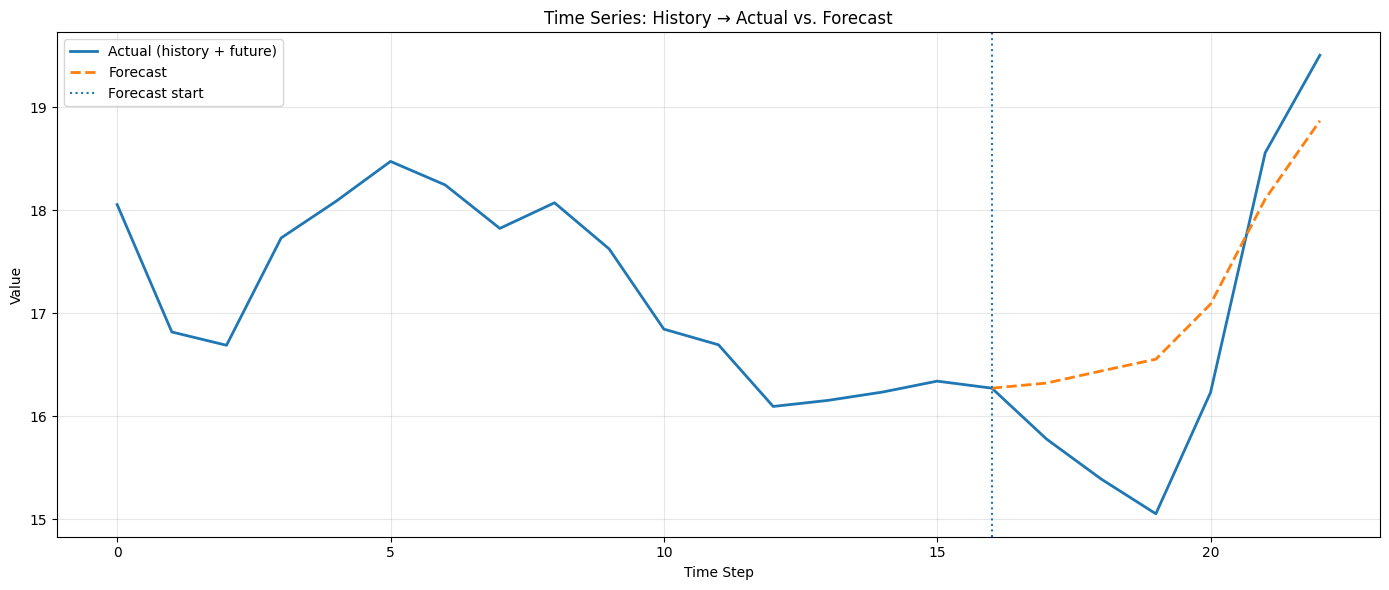

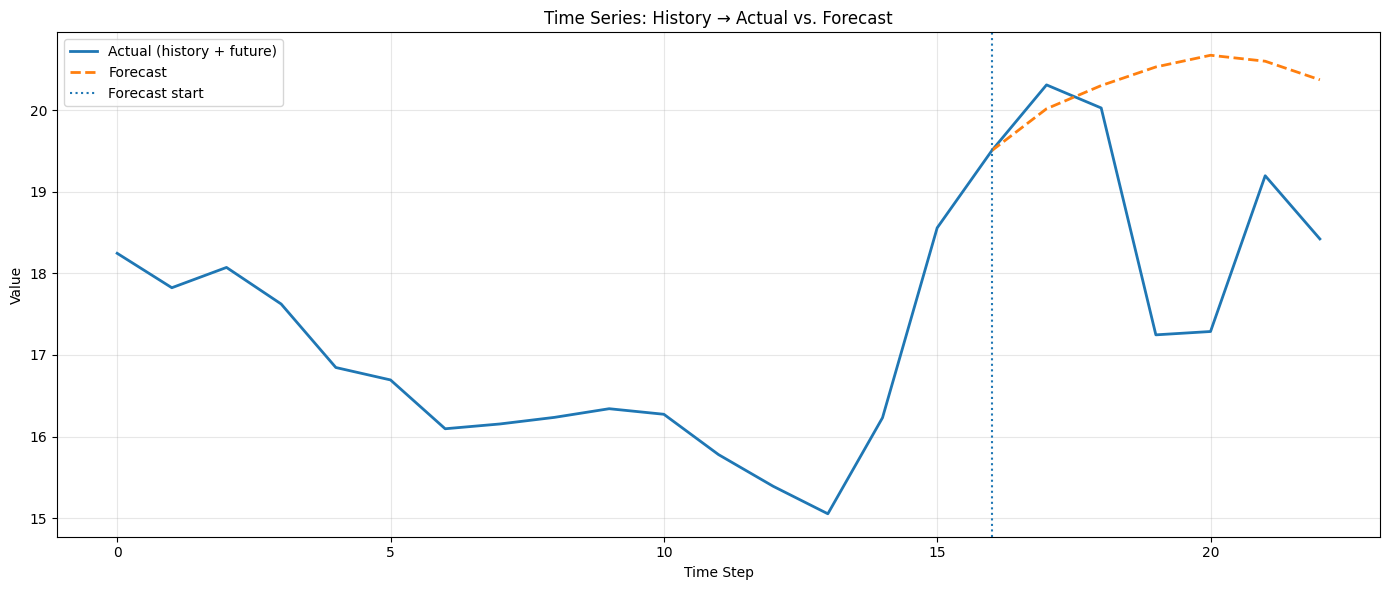

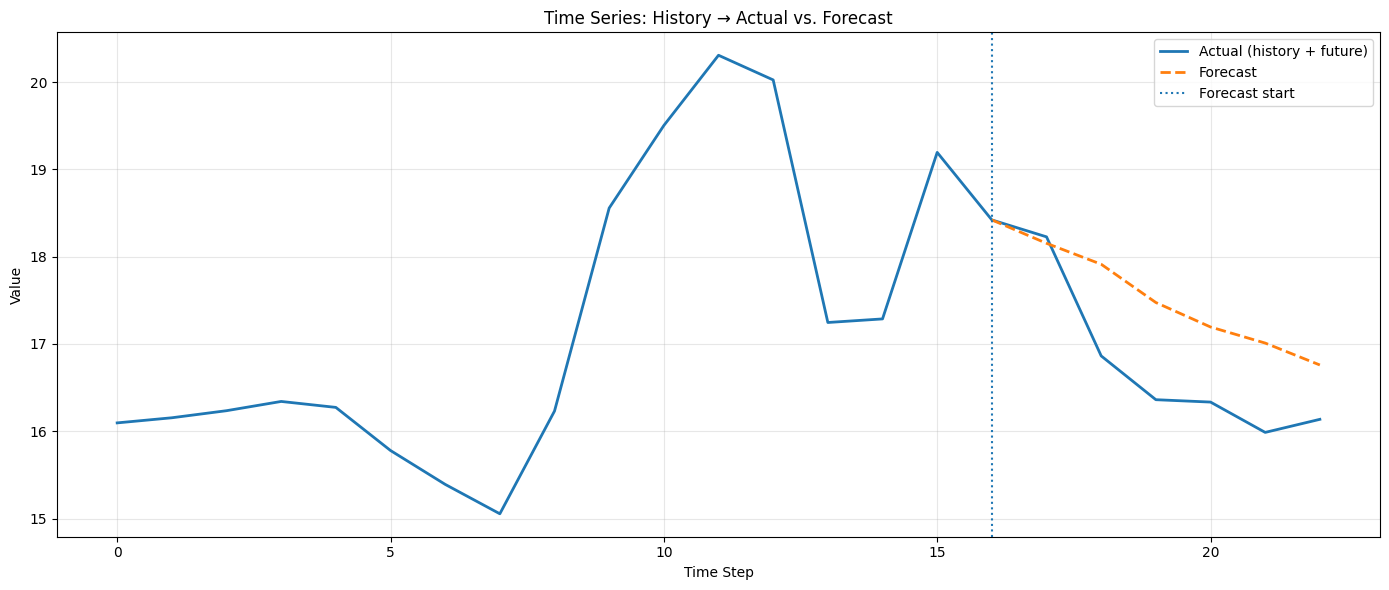

In [12]:
for batch in dataset_val.take(1):
    (x_past, x_future), y = batch
    predictions = model.predict((x_past, x_future))

    print("predictions shape:", predictions.shape[0])
    for i in range(0, 9):
        plot_predictions(x_past[i], y[i], predictions[i])
        plt.show()